In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np

from coropy.compartmental_models import SEIRDModel

In [13]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'INDIA'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)

INFO:root:L-BFGS-B optimization started: 2020-11-21 09:14:37.445024
INFO:root:Elapsed time: 4.5306s


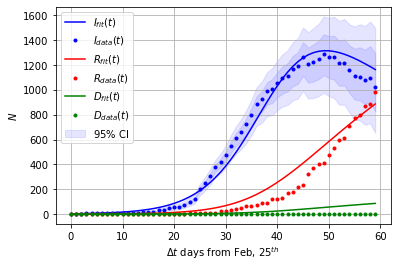

In [14]:
# instantiate a model and train it using the first bi-month data (60 days)
coff = 60

S0 = confirmed_cases[coff-1] + 0.1 * confirmed_cases[coff-1]
E0 = 3 * confirmed_cases[0]
I0 = confirmed_cases[0]
R0 = recovered_cases[0]
D0 = death_cases[0]
IC = (S0, E0, I0, R0, D0)

model = SEIRDModel(calc_ci=True, pcr_sens=0.9, pcr_spec=0.99, daily_tests=daily_tests[:coff])
params, loss = model.fit(confirmed_cases[:coff], recovered_cases[:coff], death_cases[:coff], IC)

# obtain predictions
(S, E, I, R, D) = model.simulate()

# visualize
fig, ax = plt.subplots()
ax.plot(I[2], 'b-', label='$I_{fit}(t)$')
ax.fill_between(list(range(len(I[0]))), I[0], I[4], color='b', alpha=0.1, label='$95\%$ CI')
ax.fill_between(list(range(len(I[0]))), I[1], I[3], color='b', alpha=0.1)
ax.plot(confirmed_cases[:coff] - recovered_cases[:coff] - death_cases[:coff], 'b.', label='$I_{data}(t)$')
ax.plot(R, 'r-', label='$R_{fit}(t)$')
ax.plot(recovered_cases[:coff], 'r.', label='$R_{data}(t)$')
ax.plot(D, 'g-', label='$D_{fit}(t)$')
ax.plot(death_cases[:coff], 'g.', label='$D_{data}(t)$')
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend()
ax.grid()
plt.show()

INFO:root:L-BFGS-B optimization started: 2020-11-21 09:14:43.038319
INFO:root:Elapsed time: 32.9956s


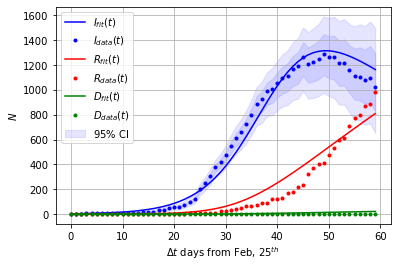

In [15]:
# instantiate a model and train it using the first bi-month data (60 days) on user defined SEIRD-based model
def SEIRD_ode(t, y, beta, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

model2 = SEIRDModel(ode_system=SEIRD_ode, calc_ci=True, pcr_sens=0.9, pcr_spec=0.99, daily_tests=daily_tests[:coff])
params, loss = model2.fit(confirmed_cases[:coff], recovered_cases[:coff], death_cases[:coff], IC, guess=[0.1]*5)

# obtain predictions
(S2, E2, I2, R2, D2) = model2.simulate()

# visualize
fig, ax = plt.subplots()
ax.plot(I[2], 'b-', label='$I_{fit}(t)$')
ax.fill_between(list(range(len(I2[0]))), I2[0], I2[4], color='b', alpha=0.1, label='$95\%$ CI')
ax.fill_between(list(range(len(I2[0]))), I2[1], I2[3], color='b', alpha=0.1)
ax.plot(confirmed_cases[:coff] - recovered_cases[:coff] - death_cases[:coff], 'b.', label='$I_{data}(t)$')
ax.plot(R2, 'r-', label='$R_{fit}(t)$')
ax.plot(recovered_cases[:coff], 'r.', label='$R_{data}(t)$')
ax.plot(D2, 'g-', label='$D_{fit}(t)$')
ax.plot(death_cases[:coff], 'g.', label='$D_{data}(t)$')
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend()
ax.grid()
plt.show()

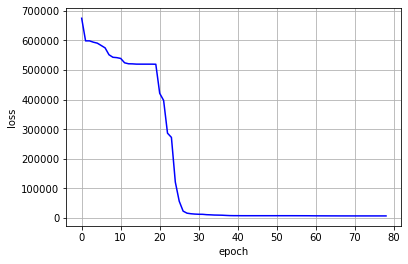

In [16]:
# plot loss function
fig, ax = plt.subplots()
ax.plot(loss, 'b-', label='loss(epoch)')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid()
plt.show()

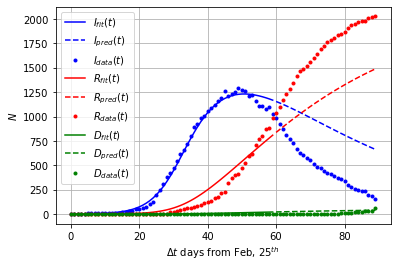

In [17]:
# forecasting
n_days = 30
_, _, I2_p, R2_p, D2_p = model2.forecast(n_days)

# visualize
x = list(range(I2[2].size))
x_p = list(range(I2[2].size, I2[2].size + I2_p.size))
fig, ax = plt.subplots()
ax.plot(x, I2[2], 'b-', label='$I_{fit}(t)$')
ax.plot(x_p, I2_p, 'b--', label='$I_{pred}(t)$')
ax.plot(confirmed_cases[:coff+n_days] - recovered_cases[:coff+n_days] - death_cases[:coff+n_days], 'b.', label='$I_{data}(t)$')
ax.plot(x, R2, 'r-', label='$R_{fit}(t)$')
ax.plot(x_p, R2_p, 'r--', label='$R_{pred}(t)$')
ax.plot(recovered_cases[:coff+n_days], 'r.', label='$R_{data}(t)$')
ax.plot(x, D2, 'g-', label='$D_{fit}(t)$')
ax.plot(x_p, D2_p, 'g--', label='$D_{pred}(t)$')
ax.plot(death_cases[:coff+n_days], 'g.', label='$D_{data}(t)$')
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend()
ax.grid()
plt.show()

In [18]:
model2.get_params

array([8.80018368e-01, 1.00000000e-05, 7.67256152e-02, 2.46912533e-02,
       6.59609391e-04])